In [2]:
import pandas as pd
import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
tf.keras.layers.Dense(100)
from utils.gpu_memory_grow import gpu_memory_grow

import matplotlib.pyplot as plt
import itertools
from models.evaluation import utils
from utils import eval_methods, dataLoader, simple_metric

# from configs.mts_style_transfer_v2.args import DafaultArguments as args
from configs.mts_style_transfer_v2.args_sim import DafaultArguments as args
# from configs.mts_style_transfer_v2.args_real import DafaultArguments as args

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import umap
from sklearn.manifold import TSNE


gpus = tf.config.list_physical_devices('GPU')
gpu_memory_grow(gpus)

2024-09-24 14:06:47.169571: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-24 14:06:47.208483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 14:06:47.208512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 14:06:47.209540: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 14:06:47.216490: I tensorflow/core/platform/cpu_feature_guar

1 Physical GPUs, 1 Logical GPUs


2024-09-24 14:06:53.228471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17675 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2d:00.0, compute capability: 8.6


In [3]:
MODEL_TO_EVALUATE = "to_evaluate/exp_folder/MTS-ST V2 TS Simulated Amplitude bigger content space"

In [4]:
def predictions_on_content_space(content_dset_path:str, content_encoder:tf.keras.Model, data_loading_arguments:dict):

    dset_content_train, dset_content_valid = utils.load_dset(content_dset_path, data_loading_arguments, drop_labels=False)

    dset_content_train= utils.encode_dataset(dset_content_train, content_encoder, data_loading_arguments)
    dset_content_valid= utils.encode_dataset(dset_content_valid, content_encoder, data_loading_arguments)

    content_perf = eval_methods.predictions_on_content_space(dset_content_train, dset_content_valid, data_loading_arguments)

    return content_perf

def load_valid_batches(content_dataset_path:str, style_dataset_path:str):
    default_parameters = args()

    sequence_length = default_parameters.simulated_arguments.sequence_lenght_in_sample
    gran = default_parameters.simulated_arguments.granularity
    overlap = default_parameters.simulated_arguments.overlap
    bs = args().simulated_arguments.batch_size
    
    _, content_dset_valid = dataLoader.loading_wrapper(
        content_dataset_path,
        sequence_length, 
        gran, 
        overlap, 
        bs)
    
    _, style_dset_valid =  dataLoader.loading_wrapper(
        style_dataset_path, 
        sequence_length, 
        gran, 
        overlap,
        bs)
    
    
    content_batch = dataLoader.get_batches(content_dset_valid, 50)
    style_batch = dataLoader.get_batches(style_dset_valid, 50) 
    
    return content_batch, style_batch

def generate(content_batch, style_batch, content_encoder, style_encoder, decoder):
    
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    
    generated = tf.concat(generated, -1)
    
    return generated

# Evaluate Trained Dataset

In [5]:
default_arguments = args()
training_arguments = utils.get_model_training_arguments(MODEL_TO_EVALUATE)
ce, se, de = utils.load_models(MODEL_TO_EVALUATE)

# Generation quality.
## Generate a "dataset" for each style.

In [6]:
def get_name(path:str):
    filename = path.split("/")[-1]
    return ".".join(filename.split('.')[:-1])

In [7]:
def stylize(
        content_dset:tf.data.Dataset, 
        style_sequence:tf.Tensor, 
        content_encoder:tf.keras.Model, 
        style_encoder:tf.keras.Model, 
        decoder:tf.keras.Model, args:dict) -> tf.data.Dataset:
    
    label_idx = int(args.simulated_arguments.sequence_lenght_in_sample//2)

    content_space = content_dset.map(lambda seq, _: (content_encoder(seq)), num_parallel_calls=tf.data.AUTOTUNE).cache()
    labels = content_dset.map(lambda _,l : l, num_parallel_calls=tf.data.AUTOTUNE).cache()
    
    style_vector = style_encoder(style_sequence)

    translated = content_space.map(lambda c: tf.concat(decoder([c, style_vector], training=False), -1), num_parallel_calls=tf.data.AUTOTUNE).cache()
    dset_final = tf.data.Dataset.zip((translated, labels))

    return dset_final


In [8]:
real_style_dataset = {}
fake_style_dataset = {}
style_names = []
bs = 256 #args().simulated_arguments.batch_size

dset_content_train, dset_content_valid = utils.load_dset(training_arguments["dset_content"], default_arguments, drop_labels=False, bs=bs)

dset_content_train = utils.extract_labels(dset_content_train, default_arguments)
dset_content_valid = utils.extract_labels(dset_content_valid, default_arguments)


for style_path in training_arguments["style_datasets"]:
    sty_name = get_name(style_path)
    style_names.append(sty_name)
    
    print(f"Making {sty_name}")
    
    dset_style_train, dset_style_valid = utils.load_dset(style_path, default_arguments, drop_labels=False, bs=bs)
    
    dset_lstyle_train = utils.extract_labels(dset_style_train, default_arguments)
    dset_lstyle_valid = utils.extract_labels(dset_style_valid, default_arguments)
        
    real_style_dataset[f"{sty_name}_train"] = dset_lstyle_train
    real_style_dataset[f"{sty_name}_valid"] = dset_lstyle_valid
    
    style_batch_train = next(iter(dset_lstyle_train))[0][0]
    style_batch_train = np.array([style_batch_train]* bs)
    
    style_batch_valid = next(iter(dset_lstyle_valid))[0][0]
    style_batch_valid = np.array([style_batch_valid]* bs)
            
    stylized_train = stylize(dset_content_train, style_batch_train, ce, se, de, default_arguments)
    stylized_valid = stylize(dset_content_valid, style_batch_valid, ce, se, de, default_arguments)
    
    fake_style_dataset[f"{sty_name}_train"] = stylized_train
    fake_style_dataset[f"{sty_name}_valid"] = stylized_valid

Making 1.0_1.0


2024-09-24 14:07:01.155818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Making 2.0_2.0
Making 3.0_3.0
Making 4.0_4.0
Making 5.0_5.0
Making 6.0_6.0
Making 7.0_7.0
Making 8.0_8.0
Making 9.0_9.0
Making 10.0_10.0


# Some Generations.

2024-09-24 14:07:59.146442: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-24 14:07:59.146520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-24 14:07:59.147143: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

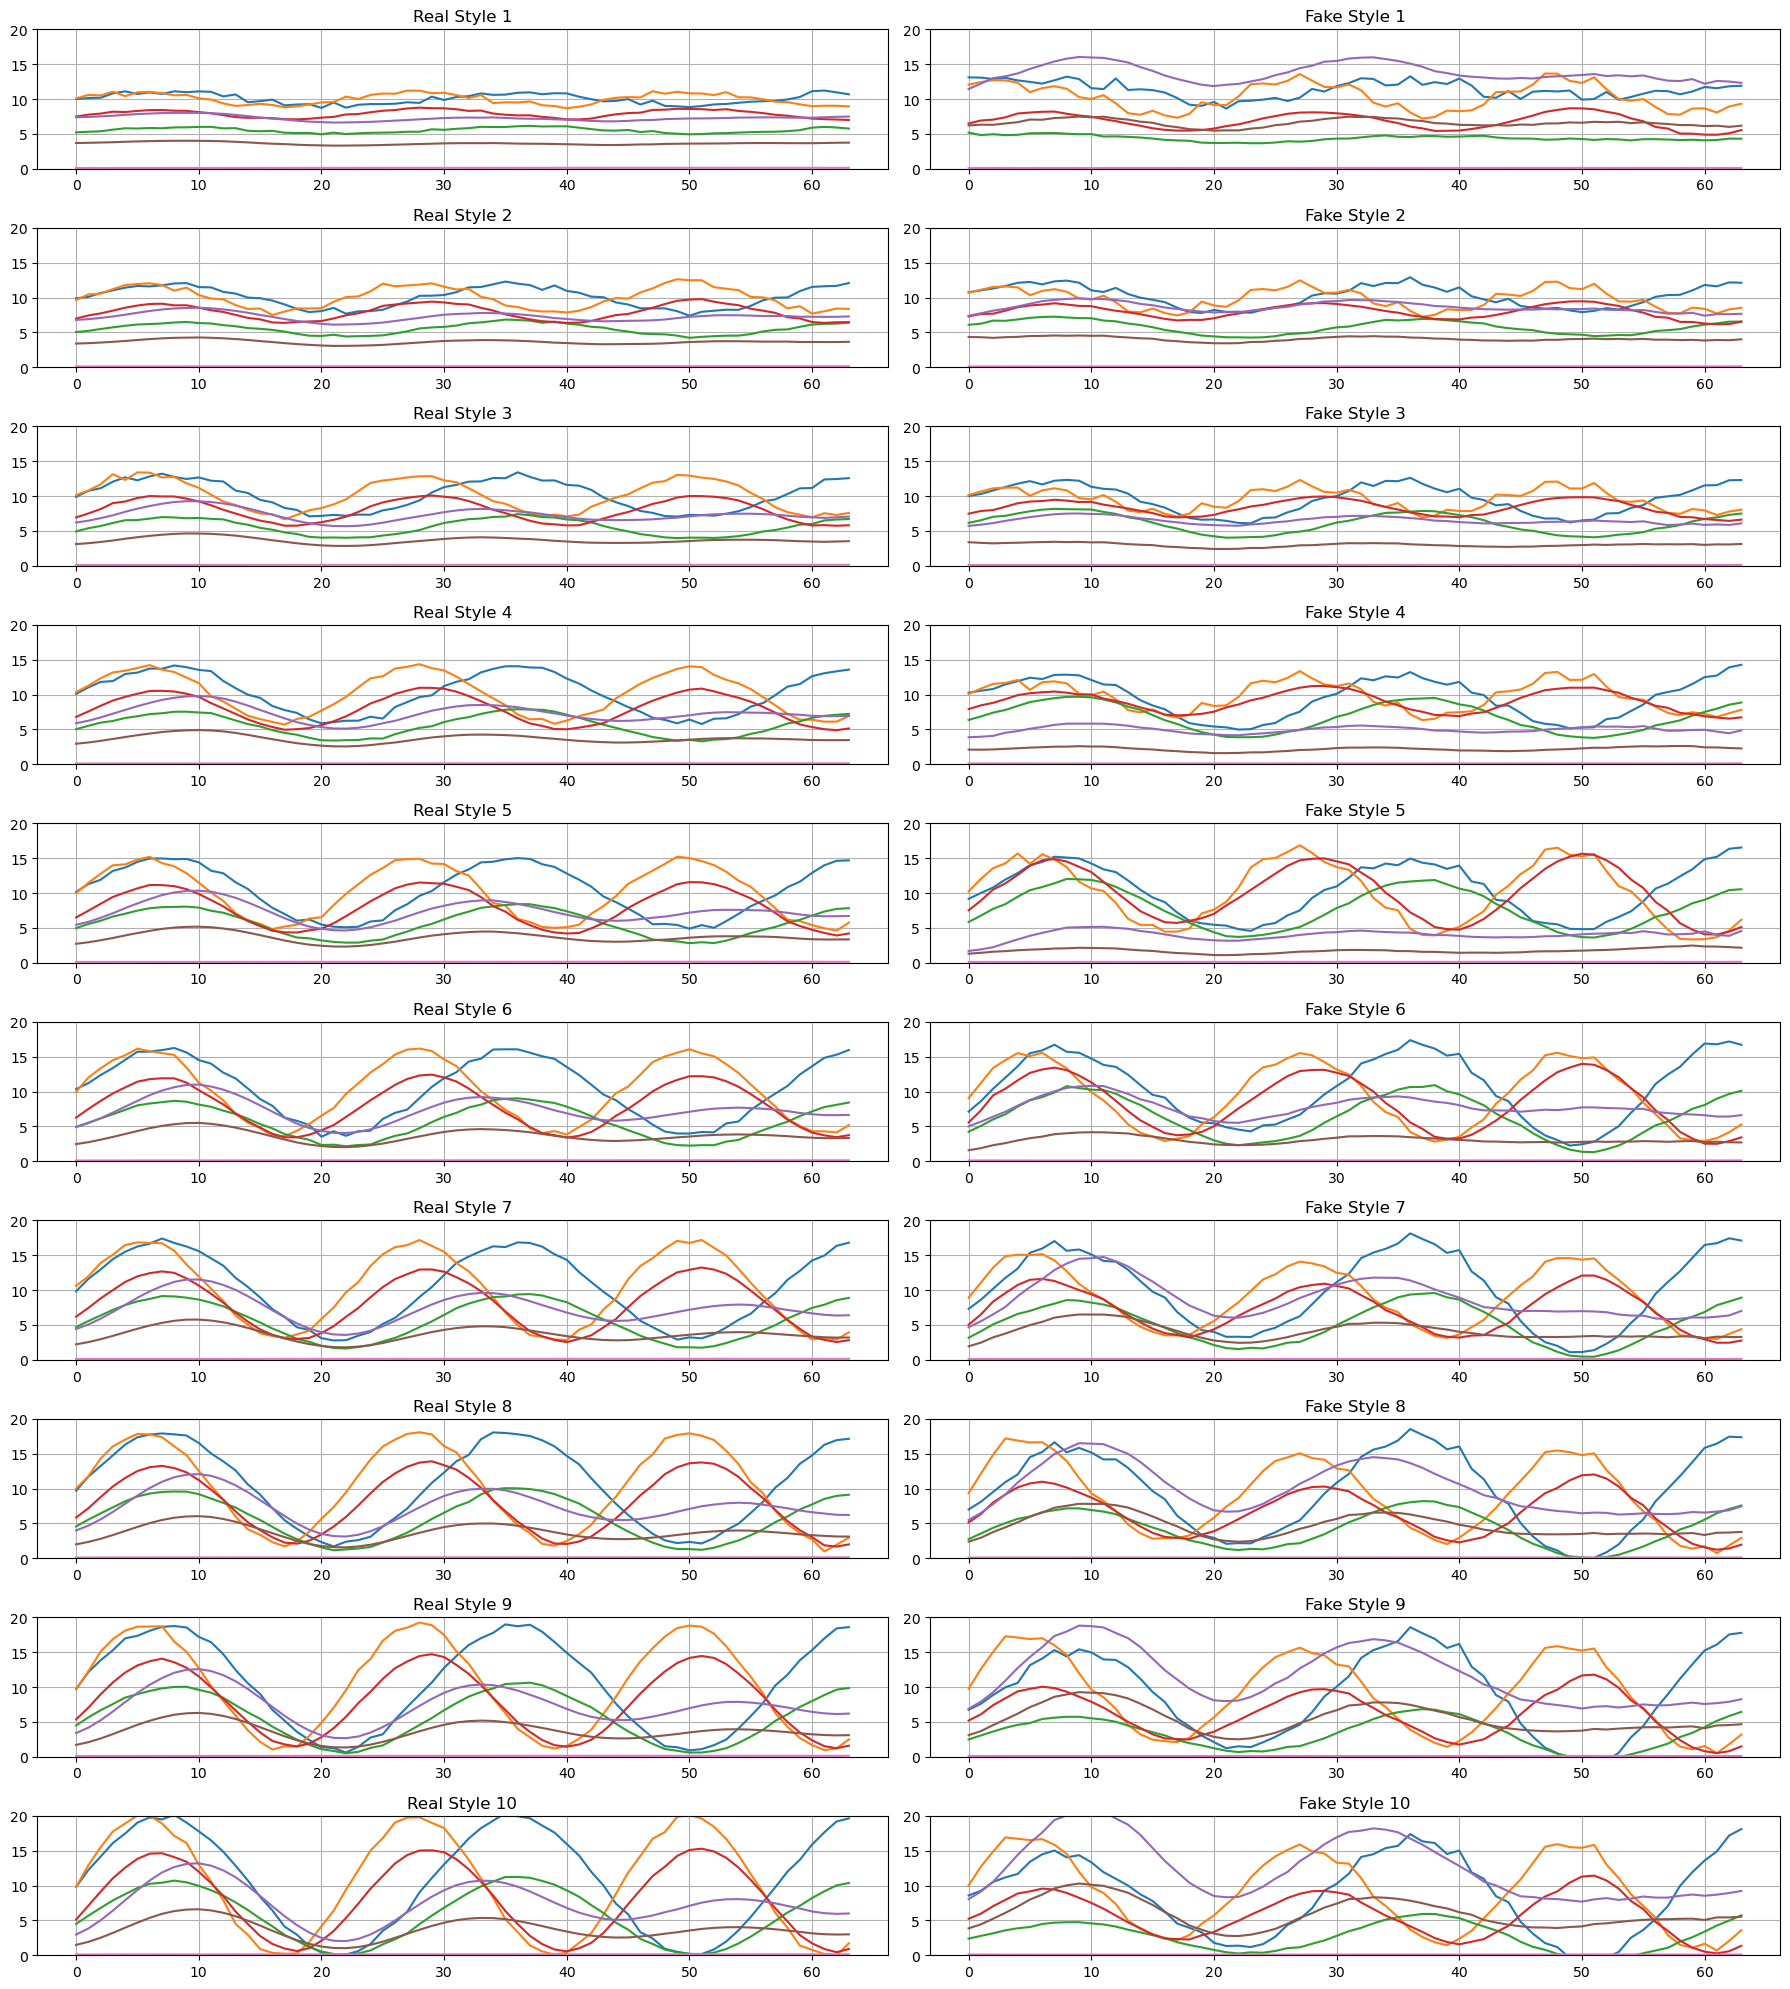

In [9]:
plt.figure(figsize=(18, 20))


for i, style_ in enumerate(style_names):
    real_style_sequence = next(iter(real_style_dataset[f"{style_}_valid"]))[0][0]
    fake_style_sequence = next(iter(fake_style_dataset[f"{style_}_valid"]))[0][0]
    
    
    ax = plt.subplot(len(style_names), 2, 2*i+1)
    ax.set_title(f"Real Style {i+1}")
    plt.plot(real_style_sequence)
    ax.grid(True)
    ax.set_ylim(-0.01, 20.01)
    
        
    ax = plt.subplot(len(style_names), 2, 2*i+2)
    ax.set_title(f"Fake Style {i+1}")
    
    plt.plot(fake_style_sequence)
    ax.set_ylim(-0.01, 20.01)
    
    
    ax.grid(True)
    
plt.tight_layout()
plt.savefig(f"{MODEL_TO_EVALUATE}/generations.png")

# TSTR

In [10]:
def tstr(
    dset_train_real,
    dset_valid_real,
    dset_train_fake, 
    dset_valid_fake, 
    save_to:str):

    print('[+] Train Real, Test Real.')
    real_performances, hist_real = eval_methods.train_naive_discriminator(dset_train_real, dset_valid_real, args(), epochs=5, n_classes=5)

    print("[+] Train Synthetic, Test Synthetic")
    gen_perf1, hist_fake1 = eval_methods.train_naive_discriminator(dset_train_fake, dset_valid_fake, args(), epochs=5, n_classes=5)
    
    print("[+] Train Synthetic, Test Real")
    gen_perf2, hist_fake2 = eval_methods.train_naive_discriminator(dset_train_fake, dset_valid_real, args(), epochs=5, n_classes=5)
    
    
    fig = plt.figure(figsize=(18, 10))
    
    ax = plt.subplot(211)
    
    plt.plot(hist_real.history["loss"], ".-", label='Train Real Test Real (Train)')
    plt.plot(hist_real.history["val_loss"], ".-", label='Train Real Test Real (Valid)')
    
    plt.plot(hist_fake1.history["loss"], ".-", label='Train Synthetic, Test Synthetic (Train)')
    plt.plot(hist_fake1.history["val_loss"], ".-", label='Train Synthetic, Test Synthetic (Valid)')
    
    plt.plot(hist_fake2.history["loss"], ".-", label='Train Real, Test Synthetic (Train)')
    plt.plot(hist_fake2.history["val_loss"], ".-", label='Train Real, Test Synthetic (Valid)')
    
    ax.legend()
    ax.grid()
    ax = plt.subplot(212)
    
    plt.plot(hist_real.history["sparse_categorical_accuracy"], ".-", label='Classification Acc on Real (Train)')
    plt.plot(hist_real.history["val_sparse_categorical_accuracy"], ".-", label='Classification Acc on Real (Valid)')
    
    plt.plot(hist_fake1.history["sparse_categorical_accuracy"], ".-", label='Train Synthetic, Test Synthetic (Train)')
    plt.plot(hist_fake1.history["val_sparse_categorical_accuracy"], ".-", label='Train Synthetic, Test Synthetic (Valid)')
    
    plt.plot(hist_fake2.history["sparse_categorical_accuracy"], ".-", label='Train Real, Test Synthetic (Train)')
    plt.plot(hist_fake2.history["val_sparse_categorical_accuracy"], ".-", label='Train Real, Test Synthetic (Valid)')
    
    ax.grid()
    ax.legend()
    
    plt.savefig(save_to)
    
    plt.close(fig)
    
    return real_performances, gen_perf2

In [11]:
tstr_stats = {}

for i, style_ in enumerate(style_names):
    print(f'[+] Training on dataset {style_}.')
    
    perf_on_real, perf_on_fake = tstr(
        real_style_dataset[f"{style_}_train"],
        real_style_dataset[f"{style_}_valid"],
        fake_style_dataset[f"{style_}_train"],
        fake_style_dataset[f"{style_}_valid"], 
        f'{MODEL_TO_EVALUATE}/tstr_{style_}.png'
        )
    
    tstr_stats[f"{style_}_real"] = [perf_on_real]
    tstr_stats[f"{style_}_gen"] = [perf_on_fake]
    
tstr_stats = pd.DataFrame.from_dict(tstr_stats)

tstr_stats.to_hdf(f"{MODEL_TO_EVALUATE}/tstr.h5", key="data")


[+] Training on dataset 1.0_1.0.
[+] Train Real, Test Real.
Epoch 1/5


2024-09-24 14:08:53.287486: I external/local_xla/xla/service/service.cc:168] XLA service 0x7bdb463631b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-24 14:08:53.287513: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-24 14:08:53.292998: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727179733.403172  660031 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1038/Unknown - 20s 17ms/step - loss: 0.1938 - sparse_categorical_accuracy: 0.9395

2024-09-24 14:09:11.866950: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:09:11.867034: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 21ms/step - loss: 0.1934 - sparse_categorical_accuracy: 0.9397 - val_loss: 0.0295 - val_sparse_categorical_accuracy: 0.9936
Epoch 2/5


2024-09-24 14:09:16.724050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:09:16.724135: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 23s 22ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0192 - val_sparse_categorical_accuracy: 0.9933
Epoch 3/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0136 - val_sparse_categorical_accuracy: 0.9942
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9962 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 0.9960
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9984
[+] Train Synthetic, Test Synthetic


2024-09-24 14:10:57.111728: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:10:57.111806: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1033/Unknown - 50s 46ms/step - loss: 1.5605 - sparse_categorical_accuracy: 0.2921

2024-09-24 14:11:48.478792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:11:48.478902: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 64s 59ms/step - loss: 1.5603 - sparse_categorical_accuracy: 0.2922 - val_loss: 1.5379 - val_sparse_categorical_accuracy: 0.2986
Epoch 2/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5379 - sparse_categorical_accuracy: 0.2939 - val_loss: 1.5359 - val_sparse_categorical_accuracy: 0.2919
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5370 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.5361 - val_sparse_categorical_accuracy: 0.3009
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.2944 - val_loss: 1.5360 - val_sparse_categorical_accuracy: 0.2945
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5361 - sparse_categorical_accuracy: 0.2945
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:12:29.601240: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:12:29.601332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1040/Unknown - 7s 6ms/step - loss: 1.5563 - sparse_categorical_accuracy: 0.2932

2024-09-24 14:12:36.500609: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:12:36.500703: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5563 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.6550 - val_sparse_categorical_accuracy: 0.1601
Epoch 2/5
  20/1041 [..............................] - ETA: 5s - loss: 1.5423 - sparse_categorical_accuracy: 0.2977

2024-09-24 14:12:41.075366: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:12:41.075446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5392 - sparse_categorical_accuracy: 0.2924 - val_loss: 1.5725 - val_sparse_categorical_accuracy: 0.1459
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5374 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.5627 - val_sparse_categorical_accuracy: 0.1434
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.2934 - val_loss: 1.5566 - val_sparse_categorical_accuracy: 0.0881
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5809 - sparse_categorical_accuracy: 0.0243


2024-09-24 14:13:27.214518: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:13:27.214614: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 2.0_2.0.
[+] Train Real, Test Real.
Epoch 1/5
   1034/Unknown - 20s 18ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9540

2024-09-24 14:13:47.364244: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:13:47.364337: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 25s 23ms/step - loss: 0.1524 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.0124 - val_sparse_categorical_accuracy: 0.9962
Epoch 2/5


2024-09-24 14:13:52.159252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:13:52.159332: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0047 - val_sparse_categorical_accuracy: 0.9992
Epoch 3/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0037 - val_sparse_categorical_accuracy: 0.9988
Epoch 4/5
1041/1041 [==============================] - 25s 24ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0074 - val_sparse_categorical_accuracy: 0.9965
Epoch 5/5
260/260 [==============================] - 5s 17ms/step - loss: 0.0024 - sparse_categorical_accuracy: 0.9993
[+] Train Synthetic, Test Synthetic


2024-09-24 14:15:34.315308: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:15:34.315378: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 51s 47ms/step - loss: 1.5762 - sparse_categorical_accuracy: 0.2920

2024-09-24 14:16:26.600450: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 64s 60ms/step - loss: 1.5759 - sparse_categorical_accuracy: 0.2921 - val_loss: 1.5528 - val_sparse_categorical_accuracy: 0.2968
Epoch 2/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5391 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.5364 - val_sparse_categorical_accuracy: 0.3012
Epoch 3/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5375 - sparse_categorical_accuracy: 0.2938 - val_loss: 1.5374 - val_sparse_categorical_accuracy: 0.2996
Epoch 4/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2920 - val_loss: 1.5363 - val_sparse_categorical_accuracy: 0.2896
Epoch 5/5
260/260 [==============================] - 1s 4ms/step - loss: 1.5362 - sparse_categorical_accuracy: 0.2945
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:17:07.130225: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:17:07.130313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1036/Unknown - 7s 6ms/step - loss: 1.5592 - sparse_categorical_accuracy: 0.2929

2024-09-24 14:17:14.037120: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:17:14.037215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 12s 10ms/step - loss: 1.5591 - sparse_categorical_accuracy: 0.2930 - val_loss: 1.6301 - val_sparse_categorical_accuracy: 0.1527
Epoch 2/5
  29/1041 [..............................] - ETA: 5s - loss: 1.5429 - sparse_categorical_accuracy: 0.2954

2024-09-24 14:17:18.885864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:17:18.885934: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5383 - sparse_categorical_accuracy: 0.2938 - val_loss: 1.5805 - val_sparse_categorical_accuracy: 0.1163
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.2928 - val_loss: 1.5293 - val_sparse_categorical_accuracy: 0.1577
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2934 - val_loss: 1.5186 - val_sparse_categorical_accuracy: 0.3457
Epoch 5/5
260/260 [==============================] - 5s 17ms/step - loss: 1.5172 - sparse_categorical_accuracy: 0.3862


2024-09-24 14:18:05.195562: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:18:05.195634: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 3.0_3.0.
[+] Train Real, Test Real.
Epoch 1/5
   1038/Unknown - 19s 18ms/step - loss: 0.0899 - sparse_categorical_accuracy: 0.9749

2024-09-24 14:18:25.068667: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:18:25.068748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0897 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.0053 - val_sparse_categorical_accuracy: 0.9997
Epoch 2/5


2024-09-24 14:18:29.786813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:18:29.786908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0062 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0018 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9992 - val_loss: 6.8397e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 26s 25ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9983 - val_loss: 8.2750e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 3.3684e-04 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:20:18.098401: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:20:18.098475: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
1041/1041 [==============================] - 64s 60ms/step - loss: 1.5687 - sparse_categorical_accuracy: 0.2926 - val_loss: 1.5385 - val_sparse_categorical_accuracy: 0.2914
Epoch 2/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5382 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.5370 - val_sparse_categorical_accuracy: 0.2967
Epoch 3/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.5368 - val_sparse_categorical_accuracy: 0.2977
Epoch 4/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.2931 - val_loss: 1.5360 - val_sparse_categorical_accuracy: 0.3016
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5361 - sparse_categorical_accuracy: 0.3075
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:21:50.619399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:21:50.619489: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1035/Unknown - 7s 6ms/step - loss: 1.5771 - sparse_categorical_accuracy: 0.2916

2024-09-24 14:21:57.465050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:21:57.465131: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5769 - sparse_categorical_accuracy: 0.2916 - val_loss: 1.5117 - val_sparse_categorical_accuracy: 0.3508
Epoch 2/5
  28/1041 [..............................] - ETA: 5s - loss: 1.5426 - sparse_categorical_accuracy: 0.2895

2024-09-24 14:22:02.062573: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:22:02.062671: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5386 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.5576 - val_sparse_categorical_accuracy: 0.3077
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5375 - sparse_categorical_accuracy: 0.2945 - val_loss: 1.5119 - val_sparse_categorical_accuracy: 0.3567
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.4610 - val_sparse_categorical_accuracy: 0.4707
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.4709 - sparse_categorical_accuracy: 0.3678


2024-09-24 14:22:48.621411: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:22:48.621480: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 4.0_4.0.
[+] Train Real, Test Real.
Epoch 1/5
   1041/Unknown - 20s 18ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9740

2024-09-24 14:23:08.693095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:23:08.693179: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.0049 - val_sparse_categorical_accuracy: 0.9992
Epoch 2/5


2024-09-24 14:23:13.406897: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:23:13.406973: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0015 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0035 - sparse_categorical_accuracy: 0.9991 - val_loss: 7.3851e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0013 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 0.9998
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 2.3081e-04 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:24:53.704675: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:24:53.704735: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 51s 47ms/step - loss: 1.5667 - sparse_categorical_accuracy: 0.2918

2024-09-24 14:25:46.020285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:25:46.020353: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 65s 60ms/step - loss: 1.5665 - sparse_categorical_accuracy: 0.2917 - val_loss: 1.5446 - val_sparse_categorical_accuracy: 0.2915
Epoch 2/5
  19/1041 [..............................] - ETA: 5s - loss: 1.5425 - sparse_categorical_accuracy: 0.2897

2024-09-24 14:25:59.811441: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:25:59.811541: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 7s 7ms/step - loss: 1.5390 - sparse_categorical_accuracy: 0.2938 - val_loss: 1.5374 - val_sparse_categorical_accuracy: 0.2853
Epoch 3/5
1041/1041 [==============================] - 7s 7ms/step - loss: 1.5377 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.5378 - val_sparse_categorical_accuracy: 0.2830
Epoch 4/5
1041/1041 [==============================] - 7s 7ms/step - loss: 1.5370 - sparse_categorical_accuracy: 0.2931 - val_loss: 1.5364 - val_sparse_categorical_accuracy: 0.3015
Epoch 5/5
260/260 [==============================] - 1s 4ms/step - loss: 1.5360 - sparse_categorical_accuracy: 0.2869
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:26:28.697992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:26:28.698057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


   1038/Unknown - 7s 6ms/step - loss: 1.5758 - sparse_categorical_accuracy: 0.2924

2024-09-24 14:26:35.500086: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5757 - sparse_categorical_accuracy: 0.2923 - val_loss: 1.6263 - val_sparse_categorical_accuracy: 0.3278
Epoch 2/5
  37/1041 [>.............................] - ETA: 4s - loss: 1.5424 - sparse_categorical_accuracy: 0.2901

2024-09-24 14:26:40.113377: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:26:40.113452: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5404 - sparse_categorical_accuracy: 0.2945 - val_loss: 1.6601 - val_sparse_categorical_accuracy: 0.2804
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5379 - sparse_categorical_accuracy: 0.2928 - val_loss: 1.6646 - val_sparse_categorical_accuracy: 0.3169
Epoch 4/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.2929 - val_loss: 1.6764 - val_sparse_categorical_accuracy: 0.2984
Epoch 5/5
260/260 [==============================] - 5s 20ms/step - loss: 1.5908 - sparse_categorical_accuracy: 0.3483


2024-09-24 14:27:26.947993: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:27:26.948057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 5.0_5.0.
[+] Train Real, Test Real.
Epoch 1/5
   1036/Unknown - 19s 17ms/step - loss: 0.0888 - sparse_categorical_accuracy: 0.9744

2024-09-24 14:27:46.558249: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:27:46.558334: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0884 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0034 - val_sparse_categorical_accuracy: 0.9999
Epoch 2/5


2024-09-24 14:27:51.420379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:27:51.420468: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0037 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0024 - val_sparse_categorical_accuracy: 0.9994
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0021 - sparse_categorical_accuracy: 0.9994 - val_loss: 2.5125e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9987 - val_loss: 3.2747e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.7062e-04 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:29:32.053148: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:29:32.053223: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 48s 45ms/step - loss: 1.5534 - sparse_categorical_accuracy: 0.2932

2024-09-24 14:30:21.870404: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:30:21.870485: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 63s 59ms/step - loss: 1.5532 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.5380 - val_sparse_categorical_accuracy: 0.2954
Epoch 2/5
  19/1041 [..............................] - ETA: 5s - loss: 1.5384 - sparse_categorical_accuracy: 0.2876

2024-09-24 14:30:36.292688: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:30:36.292782: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 7s 7ms/step - loss: 1.5374 - sparse_categorical_accuracy: 0.2931 - val_loss: 1.5372 - val_sparse_categorical_accuracy: 0.3003
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.5369 - val_sparse_categorical_accuracy: 0.2922
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2931 - val_loss: 1.5363 - val_sparse_categorical_accuracy: 0.2919
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5361 - sparse_categorical_accuracy: 0.2945
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:31:03.970936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:31:03.971005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1039/Unknown - 7s 5ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.2903

2024-09-24 14:31:10.791414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:31:10.791506: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 12s 10ms/step - loss: 1.5789 - sparse_categorical_accuracy: 0.2903 - val_loss: 1.7103 - val_sparse_categorical_accuracy: 0.4786
Epoch 2/5
  31/1041 [..............................] - ETA: 5s - loss: 1.5425 - sparse_categorical_accuracy: 0.2908

2024-09-24 14:31:15.605645: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:31:15.605720: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5391 - sparse_categorical_accuracy: 0.2946 - val_loss: 1.6027 - val_sparse_categorical_accuracy: 0.4262
Epoch 3/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.2950 - val_loss: 1.6110 - val_sparse_categorical_accuracy: 0.4229
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2934 - val_loss: 1.5382 - val_sparse_categorical_accuracy: 0.4012
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5509 - sparse_categorical_accuracy: 0.4189


2024-09-24 14:32:03.104045: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:32:03.104127: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


[+] Training on dataset 6.0_6.0.
[+] Train Real, Test Real.
Epoch 1/5
   1041/Unknown - 20s 18ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9815

2024-09-24 14:32:22.991781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:32:22.991877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0636 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5


2024-09-24 14:32:27.520515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:32:27.520589: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0014 - sparse_categorical_accuracy: 0.9999 - val_loss: 5.2361e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0016 - sparse_categorical_accuracy: 0.9996 - val_loss: 2.6617e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 1.5551e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.8355e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 19ms/step - loss: 4.8887e-05 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:34:07.841884: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:34:07.841948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 50s 47ms/step - loss: 1.5566 - sparse_categorical_accuracy: 0.2918

2024-09-24 14:34:59.766418: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:34:59.766504: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 64s 60ms/step - loss: 1.5564 - sparse_categorical_accuracy: 0.2920 - val_loss: 1.5356 - val_sparse_categorical_accuracy: 0.2944
Epoch 2/5
  22/1041 [..............................] - ETA: 5s - loss: 1.5394 - sparse_categorical_accuracy: 0.2882

2024-09-24 14:35:13.479556: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:35:13.479642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 6s 6ms/step - loss: 1.5379 - sparse_categorical_accuracy: 0.2927 - val_loss: 1.5351 - val_sparse_categorical_accuracy: 0.2952
Epoch 3/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.5357 - val_sparse_categorical_accuracy: 0.3030
Epoch 4/5
1041/1041 [==============================] - 6s 6ms/step - loss: 1.5363 - sparse_categorical_accuracy: 0.2928 - val_loss: 1.5353 - val_sparse_categorical_accuracy: 0.2949
Epoch 5/5
260/260 [==============================] - 1s 4ms/step - loss: 1.5361 - sparse_categorical_accuracy: 0.2945
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:35:40.393701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:35:40.393769: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1032/Unknown - 7s 5ms/step - loss: 1.6627 - sparse_categorical_accuracy: 0.2902

2024-09-24 14:35:47.198585: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:35:47.198666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 12s 10ms/step - loss: 1.6616 - sparse_categorical_accuracy: 0.2904 - val_loss: 1.5971 - val_sparse_categorical_accuracy: 0.3224
Epoch 2/5
  31/1041 [..............................] - ETA: 5s - loss: 1.5509 - sparse_categorical_accuracy: 0.2906

2024-09-24 14:35:52.012803: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:35:52.012886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5437 - sparse_categorical_accuracy: 0.2942 - val_loss: 1.5558 - val_sparse_categorical_accuracy: 0.3160
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5398 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.5290 - val_sparse_categorical_accuracy: 0.3532
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5384 - sparse_categorical_accuracy: 0.2929 - val_loss: 1.5319 - val_sparse_categorical_accuracy: 0.2960
Epoch 5/5
260/260 [==============================] - 5s 20ms/step - loss: 1.5412 - sparse_categorical_accuracy: 0.1776


2024-09-24 14:36:39.021606: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:36:39.021679: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 7.0_7.0.
[+] Train Real, Test Real.
Epoch 1/5
   1038/Unknown - 20s 18ms/step - loss: 0.0944 - sparse_categorical_accuracy: 0.9727

2024-09-24 14:36:59.166751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:36:59.166833: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 25s 22ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.0053 - val_sparse_categorical_accuracy: 0.9980
Epoch 2/5


2024-09-24 14:37:03.920481: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:37:03.920557: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.0011 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0017 - sparse_categorical_accuracy: 0.9996 - val_loss: 3.4030e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 0.0026 - sparse_categorical_accuracy: 0.9993 - val_loss: 4.5018e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 20ms/step - loss: 1.4206e-04 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:38:44.605101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:38:44.605164: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 50s 47ms/step - loss: 1.5612 - sparse_categorical_accuracy: 0.2937

2024-09-24 14:39:36.683685: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:39:36.683752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 64s 60ms/step - loss: 1.5610 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.5384 - val_sparse_categorical_accuracy: 0.2977
Epoch 2/5
  20/1041 [..............................] - ETA: 5s - loss: 1.5420 - sparse_categorical_accuracy: 0.2871

2024-09-24 14:39:50.196495: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:39:50.196593: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 7s 6ms/step - loss: 1.5384 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.5393 - val_sparse_categorical_accuracy: 0.2960
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5372 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.5377 - val_sparse_categorical_accuracy: 0.2934
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2949 - val_loss: 1.5370 - val_sparse_categorical_accuracy: 0.2862
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2916
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:40:17.683983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:40:17.684059: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1033/Unknown - 7s 6ms/step - loss: 1.5553 - sparse_categorical_accuracy: 0.2920

2024-09-24 14:40:24.587949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:40:24.588042: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 12s 10ms/step - loss: 1.5551 - sparse_categorical_accuracy: 0.2919 - val_loss: 1.5317 - val_sparse_categorical_accuracy: 0.2020
Epoch 2/5
  30/1041 [..............................] - ETA: 5s - loss: 1.5402 - sparse_categorical_accuracy: 0.2961

2024-09-24 14:40:29.271305: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:40:29.271386: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5378 - sparse_categorical_accuracy: 0.2949 - val_loss: 1.5260 - val_sparse_categorical_accuracy: 0.2605
Epoch 3/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2944 - val_loss: 1.5314 - val_sparse_categorical_accuracy: 0.2143
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5362 - sparse_categorical_accuracy: 0.2937 - val_loss: 1.5349 - val_sparse_categorical_accuracy: 0.1498
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5330 - sparse_categorical_accuracy: 0.1830


2024-09-24 14:41:16.558657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:41:16.558718: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 8.0_8.0.
[+] Train Real, Test Real.
Epoch 1/5
   1034/Unknown - 20s 18ms/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9785

2024-09-24 14:41:36.677191: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:41:36.677272: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 25s 23ms/step - loss: 0.0838 - sparse_categorical_accuracy: 0.9786 - val_loss: 0.0064 - val_sparse_categorical_accuracy: 0.9980
Epoch 2/5


2024-09-24 14:41:41.637694: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:41:41.637759: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 23s 22ms/step - loss: 0.0012 - sparse_categorical_accuracy: 0.9999 - val_loss: 3.9809e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 23s 22ms/step - loss: 0.0024 - sparse_categorical_accuracy: 0.9994 - val_loss: 1.4359e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 9.1044e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.4243e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 2.2747e-05 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:43:20.557048: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:43:20.557110: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 51s 47ms/step - loss: 1.5604 - sparse_categorical_accuracy: 0.2913

2024-09-24 14:44:12.882460: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:44:12.882544: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 65s 60ms/step - loss: 1.5602 - sparse_categorical_accuracy: 0.2913 - val_loss: 1.5394 - val_sparse_categorical_accuracy: 0.3056
Epoch 2/5
  22/1041 [..............................] - ETA: 5s - loss: 1.5429 - sparse_categorical_accuracy: 0.2939

2024-09-24 14:44:26.603363: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:44:26.603476: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 7s 6ms/step - loss: 1.5380 - sparse_categorical_accuracy: 0.2941 - val_loss: 1.5367 - val_sparse_categorical_accuracy: 0.2869
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.2925 - val_loss: 1.5369 - val_sparse_categorical_accuracy: 0.2936
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5363 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.5367 - val_sparse_categorical_accuracy: 0.3004
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5368 - sparse_categorical_accuracy: 0.3024
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:44:54.342178: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:44:54.342256: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1039/Unknown - 7s 6ms/step - loss: 1.5493 - sparse_categorical_accuracy: 0.2933

2024-09-24 14:45:01.143043: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:45:01.143130: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5493 - sparse_categorical_accuracy: 0.2933 - val_loss: 1.5296 - val_sparse_categorical_accuracy: 0.2542
Epoch 2/5
  21/1041 [..............................] - ETA: 5s - loss: 1.5418 - sparse_categorical_accuracy: 0.2837

2024-09-24 14:45:05.739318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:45:05.739395: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5376 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.5284 - val_sparse_categorical_accuracy: 0.2706
Epoch 3/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5368 - sparse_categorical_accuracy: 0.2942 - val_loss: 1.5337 - val_sparse_categorical_accuracy: 0.2561
Epoch 4/5
1041/1041 [==============================] - 11s 10ms/step - loss: 1.5363 - sparse_categorical_accuracy: 0.2941 - val_loss: 1.5346 - val_sparse_categorical_accuracy: 0.3022
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5352 - sparse_categorical_accuracy: 0.2813


2024-09-24 14:45:52.373413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:45:52.373488: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 9.0_9.0.
[+] Train Real, Test Real.
Epoch 1/5
   1041/Unknown - 19s 17ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9793

2024-09-24 14:46:11.857979: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:46:11.858057: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0784 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0017 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5
   1/1041 [..............................] - ETA: 2:59 - loss: 0.0020 - sparse_categorical_accuracy: 1.0000

2024-09-24 14:46:16.405433: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:46:16.405508: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 23s 22ms/step - loss: 0.0021 - sparse_categorical_accuracy: 0.9995 - val_loss: 4.2113e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 2.5075e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.5239e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 23s 22ms/step - loss: 1.1812e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.6731e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 4.8493e-05 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:47:54.907640: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:47:54.907700: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


Epoch 1/5
   1034/Unknown - 50s 47ms/step - loss: 1.5626 - sparse_categorical_accuracy: 0.2922

2024-09-24 14:48:46.631831: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:48:46.631921: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 64s 60ms/step - loss: 1.5624 - sparse_categorical_accuracy: 0.2923 - val_loss: 1.5424 - val_sparse_categorical_accuracy: 0.2768
Epoch 2/5
  21/1041 [..............................] - ETA: 5s - loss: 1.5324 - sparse_categorical_accuracy: 0.3054

2024-09-24 14:49:00.556578: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:49:00.556663: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 7s 6ms/step - loss: 1.5386 - sparse_categorical_accuracy: 0.2949 - val_loss: 1.5374 - val_sparse_categorical_accuracy: 0.2906
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5370 - sparse_categorical_accuracy: 0.2956 - val_loss: 1.5358 - val_sparse_categorical_accuracy: 0.3032
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5364 - sparse_categorical_accuracy: 0.2948 - val_loss: 1.5364 - val_sparse_categorical_accuracy: 0.2925
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2948
[+] Train Synthetic, Test Real
Epoch 1/5


2024-09-24 14:49:28.240977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:49:28.241050: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


   1033/Unknown - 7s 6ms/step - loss: 1.5597 - sparse_categorical_accuracy: 0.2925

2024-09-24 14:49:35.282106: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:49:35.282195: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 12s 10ms/step - loss: 1.5595 - sparse_categorical_accuracy: 0.2926 - val_loss: 1.5337 - val_sparse_categorical_accuracy: 0.2605
Epoch 2/5
  28/1041 [..............................] - ETA: 5s - loss: 1.5343 - sparse_categorical_accuracy: 0.3037

2024-09-24 14:49:39.993005: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:49:39.993079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5383 - sparse_categorical_accuracy: 0.2953 - val_loss: 1.5288 - val_sparse_categorical_accuracy: 0.2336
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5368 - sparse_categorical_accuracy: 0.2960 - val_loss: 1.5321 - val_sparse_categorical_accuracy: 0.1875
Epoch 4/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5364 - sparse_categorical_accuracy: 0.2946 - val_loss: 1.5341 - val_sparse_categorical_accuracy: 0.2183
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5312 - sparse_categorical_accuracy: 0.2945


2024-09-24 14:50:26.143698: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:50:26.143771: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


[+] Training on dataset 10.0_10.0.
[+] Train Real, Test Real.
Epoch 1/5
   1035/Unknown - 19s 18ms/step - loss: 0.0745 - sparse_categorical_accuracy: 0.9798

2024-09-24 14:50:45.978838: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:50:45.978920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 24s 22ms/step - loss: 0.0740 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0016 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/5


2024-09-24 14:50:50.710710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:50:50.710784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 24s 23ms/step - loss: 0.0015 - sparse_categorical_accuracy: 0.9997 - val_loss: 2.6611e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
1041/1041 [==============================] - 24s 23ms/step - loss: 1.7668e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1132e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
1041/1041 [==============================] - 24s 23ms/step - loss: 8.0242e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 5.3814e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 2.8326e-05 - sparse_categorical_accuracy: 1.0000
[+] Train Synthetic, Test Synthetic


2024-09-24 14:52:30.767733: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:52:30.767804: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


Epoch 1/5
   1041/Unknown - 51s 47ms/step - loss: 1.5780 - sparse_categorical_accuracy: 0.2926

2024-09-24 14:53:23.163574: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:53:23.163654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 64s 60ms/step - loss: 1.5780 - sparse_categorical_accuracy: 0.2926 - val_loss: 1.5502 - val_sparse_categorical_accuracy: 0.2918
Epoch 2/5
  21/1041 [..............................] - ETA: 5s - loss: 1.5443 - sparse_categorical_accuracy: 0.3062

2024-09-24 14:53:36.735251: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:53:36.735370: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 7s 6ms/step - loss: 1.5413 - sparse_categorical_accuracy: 0.2942 - val_loss: 1.5412 - val_sparse_categorical_accuracy: 0.2872
Epoch 3/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5381 - sparse_categorical_accuracy: 0.2948 - val_loss: 1.5399 - val_sparse_categorical_accuracy: 0.2828
Epoch 4/5
1041/1041 [==============================] - 7s 6ms/step - loss: 1.5373 - sparse_categorical_accuracy: 0.2942 - val_loss: 1.5379 - val_sparse_categorical_accuracy: 0.2957
Epoch 5/5
260/260 [==============================] - 1s 3ms/step - loss: 1.5367 - sparse_categorical_accuracy: 0.2990
[+] Train Synthetic, Test Real
Epoch 1/5
   1041/Unknown - 7s 5ms/step - loss: 1.5578 - sparse_categorical_accuracy: 0.2925

2024-09-24 14:54:10.718126: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809
2024-09-24 14:54:10.718211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959


1041/1041 [==============================] - 11s 10ms/step - loss: 1.5578 - sparse_categorical_accuracy: 0.2925 - val_loss: 1.5335 - val_sparse_categorical_accuracy: 0.3345
Epoch 2/5
  31/1041 [..............................] - ETA: 5s - loss: 1.5379 - sparse_categorical_accuracy: 0.2939

2024-09-24 14:54:15.518194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:54:15.518271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


1041/1041 [==============================] - 10s 10ms/step - loss: 1.5381 - sparse_categorical_accuracy: 0.2943 - val_loss: 1.5300 - val_sparse_categorical_accuracy: 0.3355
Epoch 3/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5369 - sparse_categorical_accuracy: 0.2953 - val_loss: 1.5114 - val_sparse_categorical_accuracy: 0.3560
Epoch 4/5
1041/1041 [==============================] - 10s 10ms/step - loss: 1.5364 - sparse_categorical_accuracy: 0.2947 - val_loss: 1.5083 - val_sparse_categorical_accuracy: 0.3078
Epoch 5/5
260/260 [==============================] - 5s 18ms/step - loss: 1.5137 - sparse_categorical_accuracy: 0.2617


2024-09-24 14:55:01.373912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10336347271257988959
2024-09-24 14:55:01.373968: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6124395083634640809


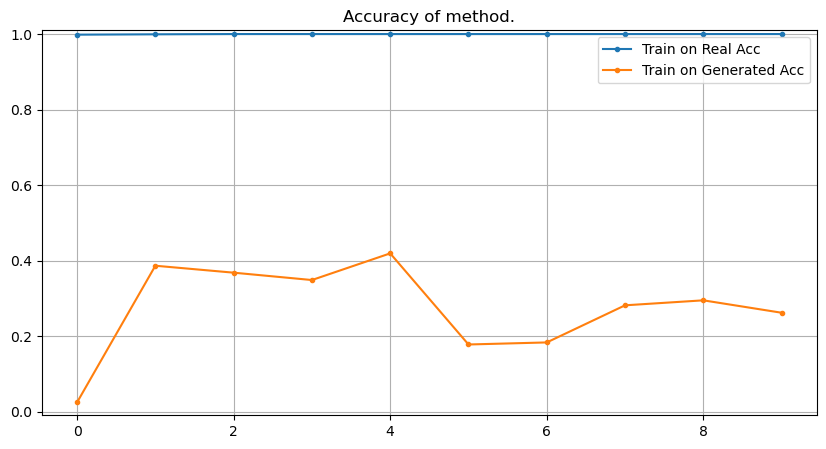

In [25]:
real_columns = [f"{sn}_real" for sn in style_names]
gen_columns = [f"{sn}_gen" for sn in style_names]

real_valid_accs = tstr_stats[real_columns].values.reshape((-1,))
gen_valid_accs = tstr_stats[gen_columns].values.reshape((-1,))


plt.figure(figsize=(10, 5))
plt.title("Accuracy of method.")

plt.plot(real_valid_accs, '.-', label='Train on Real Acc')
plt.plot(gen_valid_accs, '.-', label='Train on Generated Acc')
plt.ylim((-0.01, 1.01))
plt.xticks()
plt.grid()
plt.legend()
plt.savefig(f"{MODEL_TO_EVALUATE}/acc_results.png")
plt.show()

# UMAP Evaluation

In [13]:
def get_batches(dset, n_batches):
    _arr = np.array([c[0] for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [14]:
real_batches = []
fake_batches = []

for i, style_ in enumerate(style_names):
    real_style_batch = get_batches(real_style_dataset[f"{style_}_valid"], 10)
    fake_style_batch = get_batches(fake_style_dataset[f"{style_}_valid"], 10)
    
    real_batches.append(real_style_batch)
    fake_batches.append(fake_style_batch)
    
real_batches = np.array(real_batches)     
fake_batches = np.array(fake_batches)  

In [15]:
def multi_umap_plot(real_styles, gen_styles):
    
    (_, _, seq_len, n_sigs) = real_styles.shape
    
    concatenated = tf.concat((real_styles, gen_styles), 0)

    concatenated = tf.reshape(concatenated, (-1, seq_len, n_sigs))
    concatenated = tf.transpose(concatenated, (0, 2, 1))
        
    concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))


    # # # Normalize all sequences for the reducer.
    _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
    concatenated = (concatenated - _mean)/_std

    reducer = umap.UMAP(n_neighbors=300, min_dist=1., random_state=42, metric="euclidean") 
    reduced = reducer.fit_transform(concatenated)
    
    
    return reduced

In [16]:
real_batches.shape

(10, 2560, 64, 7)

In [17]:
reduced = multi_umap_plot(real_batches, fake_batches)

/home/henrihoyez/anaconda3/envs/tf2/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


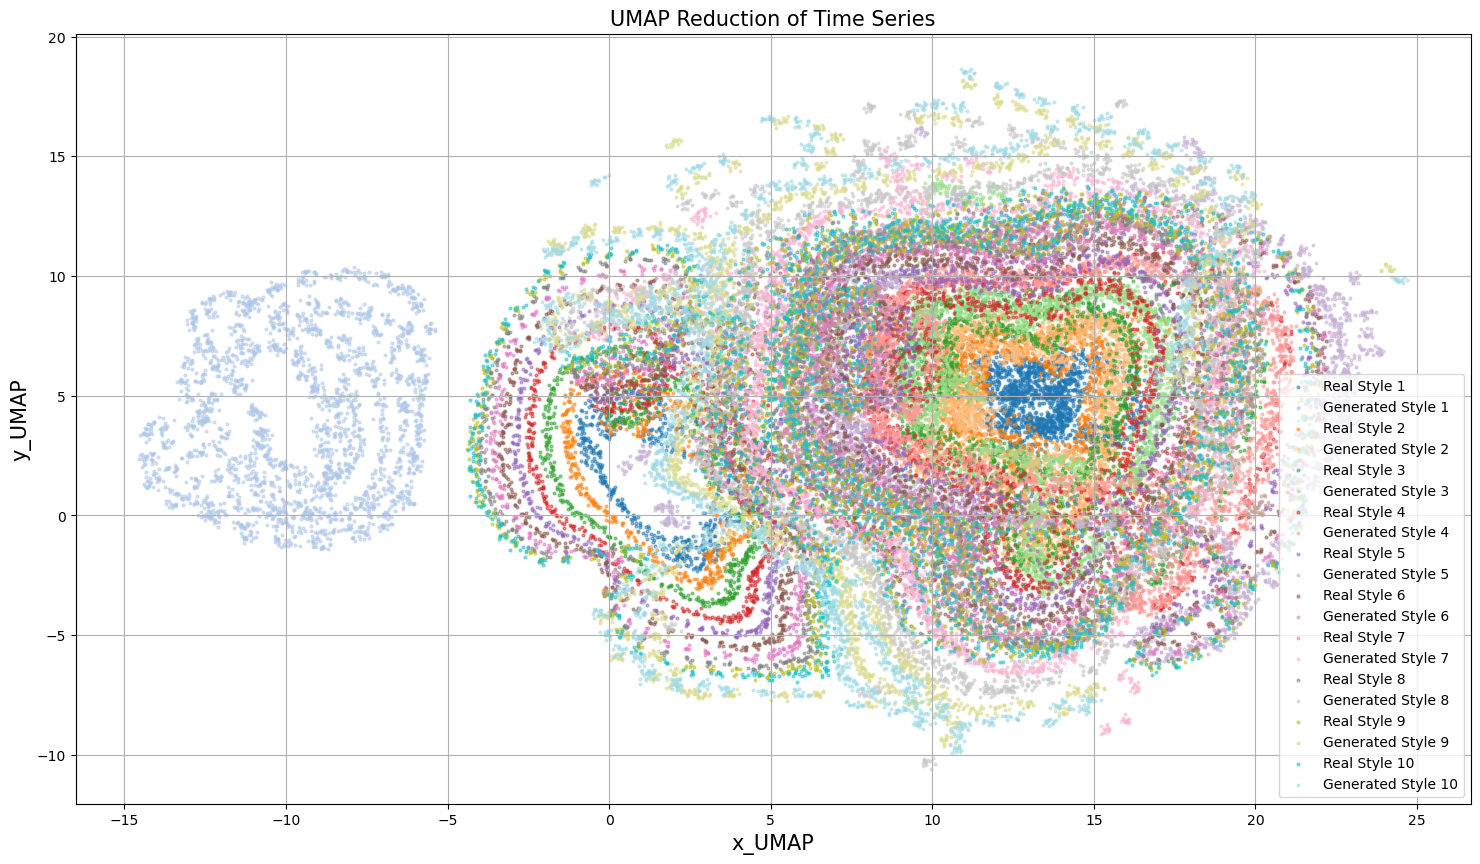

In [23]:
n_styles = len(style_names)

(n_styles, bs, seq_len, n_sigs) = real_batches.shape

cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, n_styles*2))

plt.figure(figsize=(18, 10))
for i in range(n_styles):
    ri, ro = i*bs, (i+1)*bs
    fi, fo =  (i+ n_styles) * bs, (i+ n_styles+ 1) * bs
    
    plt.scatter(reduced[ri:ro, 0], reduced[ri:ro, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i], s=4)
    plt.scatter(reduced[fi:fo, 0], reduced[fi:fo, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ], s=4)
plt.grid()
plt.title(f"UMAP Reduction of Time Series", fontsize=15)
plt.ylabel("y_UMAP", fontsize=15)
plt.xlabel("x_UMAP", fontsize=15)
plt.legend()
plt.savefig(f"{MODEL_TO_EVALUATE}/umap.png")
plt.show()

In [19]:
def tsne_plot(real_styles, gen_styles):
    (n_styles, bs, seq_len, n_sigs) = real_styles.shape
    
    concatenated = tf.concat((real_styles, gen_styles), 0)

    concatenated = tf.reshape(concatenated, (-1, seq_len, n_sigs))
    concatenated = tf.transpose(concatenated, (0, 2, 1))
        
    concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))

    # # # Normalize all sequences for the reducer.
    _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
    concatenated = (concatenated - _mean)/_std

    reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=150, random_state=42)
    reduced = reducer.fit_transform(concatenated)
        
    return reduced

In [20]:
tsne_reduced = tsne_plot(real_batches, fake_batches)

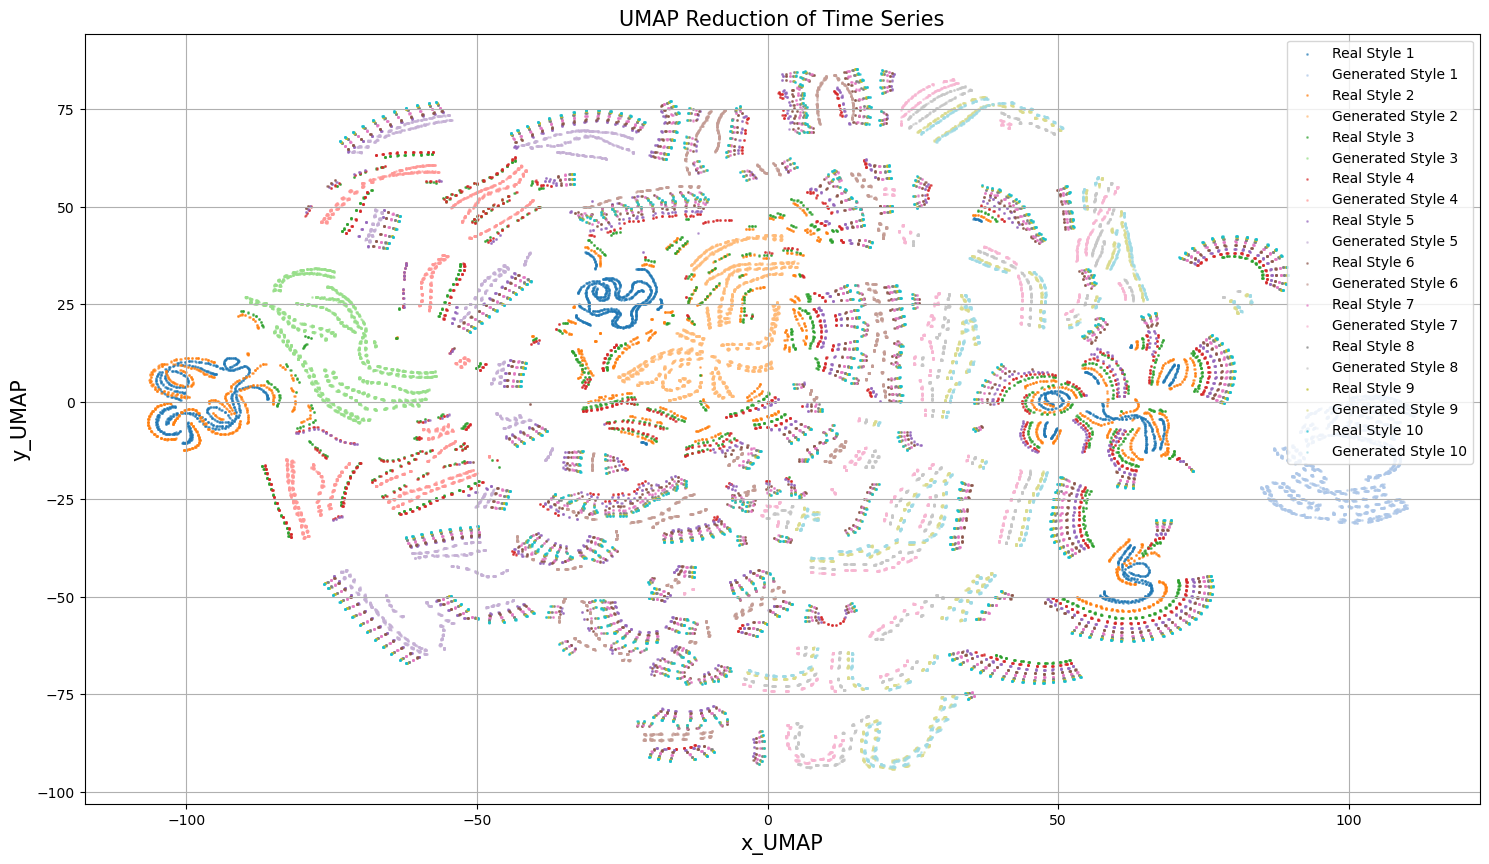

In [22]:
n_styles = len(style_names)

(n_styles, bs, seq_len, n_sigs) = real_batches.shape

cmap = plt.get_cmap("tab20")
colors = cmap(np.linspace(0, 1, n_styles*2))

plt.figure(figsize=(18, 10))
for i in range(n_styles):
    ri, ro = i*bs, (i+1)*bs
    fi, fo =  (i+ n_styles) * bs, (i+ n_styles+ 1) * bs
    
    plt.scatter(tsne_reduced[ri:ro, 0], tsne_reduced[ri:ro, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i], s=1)
    plt.scatter(tsne_reduced[fi:fo, 0], tsne_reduced[fi:fo, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ], s=1)
plt.grid()
plt.title(f"UMAP Reduction of Time Series", fontsize=15)
plt.ylabel("y_UMAP", fontsize=15)
plt.xlabel("x_UMAP", fontsize=15)
plt.legend()
plt.savefig(f"{MODEL_TO_EVALUATE}/tsne.png")
plt.show()

In [15]:
def time_shift_evaluation(big_batch):
    return [simple_metric.estimate_time_shift(big_batch, 0, i) for i in range(big_batch.shape[-1])]

In [16]:
generations = []
style_sequences = []

real_noise_metric, gen_noise_metric = [], []
real_ampl_metric, gen_ampl_metric = [], []
real_ts_metric, gen_ts_metric = [], []

for style_dset_path in training_arguments["style_datasets"]:
    print(f"Generate form dataset {style_dset_path}")
    content_batch, style_batch = load_valid_batches(training_arguments['dset_content'], style_dset_path)
    gen_seq = generate(content_batch, style_batch, ce, se, de)
    
    real_noise_metric.append(simple_metric.simple_metric_on_noise(style_batch)[1])
    gen_noise_metric.append(simple_metric.simple_metric_on_noise(gen_seq)[1])
    
    real_ampl_metric.append(simple_metric.extract_amplitude_from_signals(style_batch))
    gen_ampl_metric.append(simple_metric.extract_amplitude_from_signals(gen_seq))
    
    real_ts_metric.append(time_shift_evaluation(style_batch))
    gen_ts_metric.append(time_shift_evaluation(gen_seq))
    
    style_sequences.append(style_batch)
    generations.append(gen_seq)
    
generations = np.array(generations)
style_sequences = np.array(style_sequences)

Generate form dataset data/simulated_dataset/amplitude_shift/1.0_1.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/2.0_2.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/3.0_3.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/4.0_4.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/5.0_5.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/6.0_6.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/7.0_7.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/8.0_8.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/9.0_9.0.h5
Generate form dataset data/simulated_dataset/amplitude_shift/10.0_10.0.h5


In [17]:
# c_encoded = ce(content_batch)
# plt.figure()
# for i in range(0, 100):
#     plt.scatter(c_encoded[i,:, 0], c_encoded[i,:, 1])

In [18]:
# seq_idx = 0
# style_idx = 9

# for seq_idx in range(0, 100, 10):
#     plt.figure()

#     ax = plt.subplot(311)
#     ax.set_title("content sequence")
#     plt.plot(content_batch[seq_idx])

#     ax = plt.subplot(312)
#     ax.set_title("style sequence")
#     plt.plot(style_sequences[style_idx][0])

#     ax = plt.subplot(313)
#     ax.set_title("generated sequence")
#     plt.plot(generations[style_idx][seq_idx])

#     plt.show()


# Amplitude Metric plot

In [19]:



plt.figure(figsize=(18, 8))
plt.title("Result on Extracted Amplitudes")
plt.plot(np.mean(real_ampl_metric, axis=-1), '.-', label='Real Amplitude')
plt.plot(np.mean(gen_ampl_metric, axis=-1), '.-', label='Real Amplitude')

plt.legend()
plt.grid()

# Extract Time Shift

In [20]:

# plt.figure(figsize=(18, 8))
# plt.title("Result on Extracted Time Shift")
# plt.plot(np.mean(real_ts_metric, axis=-1), '.-', label='Real Time shift')
# plt.plot(np.mean(gen_ts_metric, axis=-1), '.-', label='Real Time Shift')

# plt.legend()
# plt.grid()

# Extracted Noise

In [21]:
# plt.figure(figsize=(18, 8))
# plt.title("Result on Extracted Amplitudes")
# plt.plot(np.mean(real_noise_metric, axis=-1), '.-', label='Extracted Noise on Real')
# plt.plot(np.mean(gen_noise_metric, axis=-1), '.-', label='Extracte Noise on Fake')

# plt.legend()
# plt.grid()